In [2]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import jams
from scipy.interpolate import interp1d
import pretty_midi

import src.models as models
import src.spectrograms as spec
import src.utils as utils
import src.init as init

In [3]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)
if torch.cuda.is_available():
    dev = "cuda:0"
    torch.set_default_device(dev)
elif torch.backends.mps.is_available():
    dev = torch.device("mps")
    torch.set_default_device(dev)
else:
    print(f"{torch.cuda.is_available()}")
    dev = "cpu"

In [3]:
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
mu = models.MU_NMF(n_iter=10, W_path=W_path)
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, hidden=16, n_iter=10, n_init_steps=1, shared=True, return_layers=False, aw_2d=False, clip_H=False, dtype=None)
ralmu = ralmu.to(dev)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt', map_location=dev)
ralmu.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [33]:
y, sr = torchaudio.load("piano-dataset/audios/example-1.wav")
eps = 1e-6

M, times, freqs_M = spec.cqt_spec(y, sr)
# W, freqs, sample_rate, true_freqs = init.init_W(W_path)#, normalize_thresh=0.1)
# H = init.init_H(l=88, t=M.shape[1], W=W, M=M, n_init_steps=10, device=dev)

midi, onset, offset, _ = spec.midi_to_pianoroll(f"piano-dataset/midis/example-1.mid", y, times, hop_length=128, sr=sr)
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
H = init.MIDI_to_H(midi, active_midi, onset, offset)

M_norm, norm_M = spec.l1_norm(M, threshold=0.01, set_min=eps)
H_norm, norm = spec.l1_norm(H, threshold=0.01, set_min=eps)
norm = norm.to(dev)

M = M.to(dev)
W_hat_mu, H_hat_mu, M_hat_mu, _ = mu(M_norm, dev)
W_hat_ralmu, H_hat_ralmu, M_hat_ralmu, _ = ralmu(M_norm, dev)

Split the dataset - done ✓


16it [00:00, 26.50it/s]
/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()


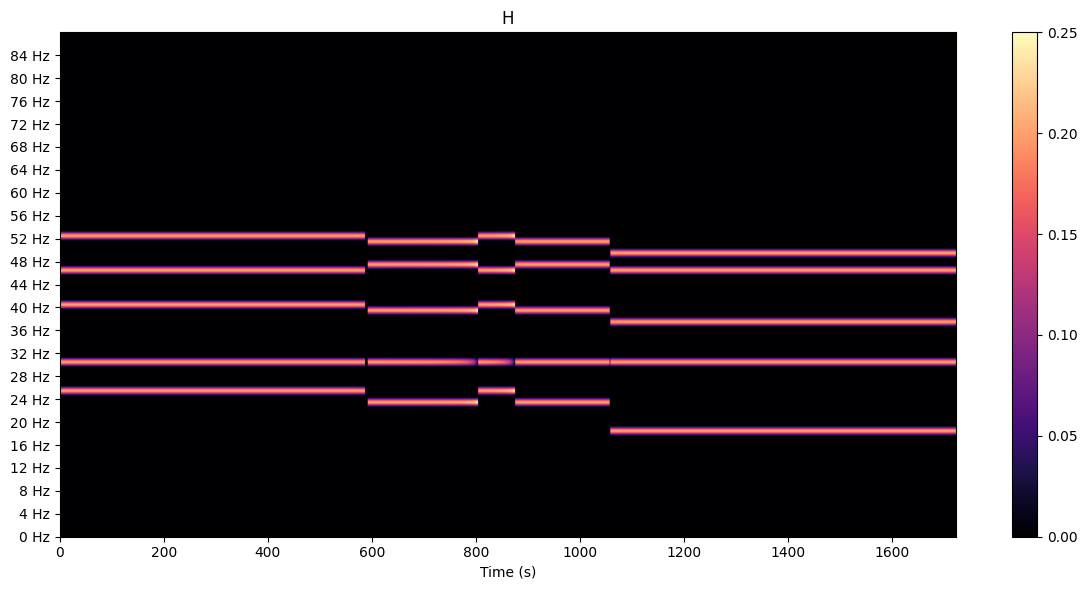

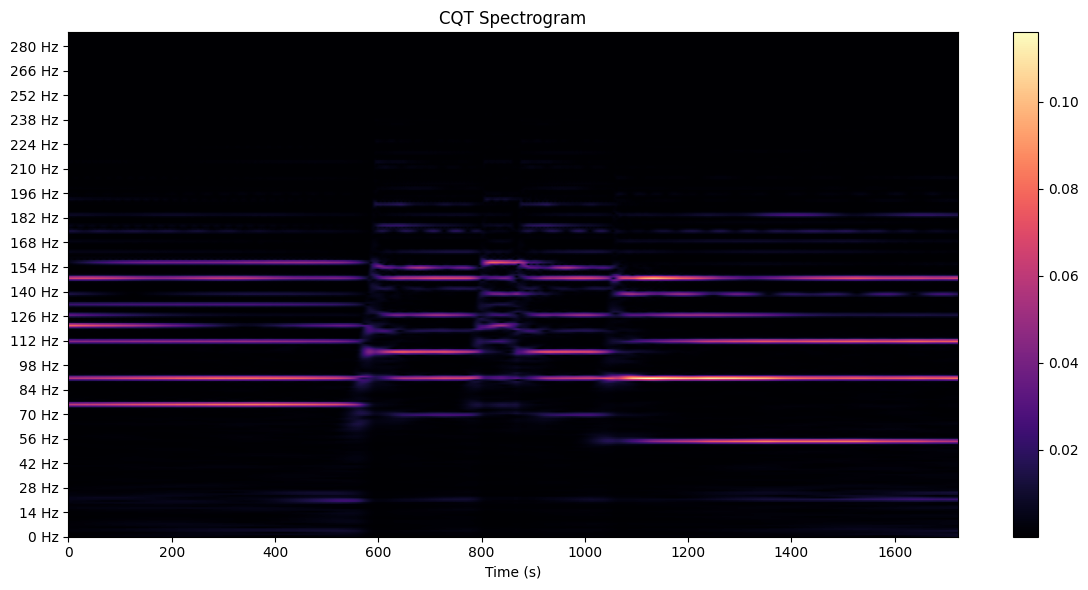

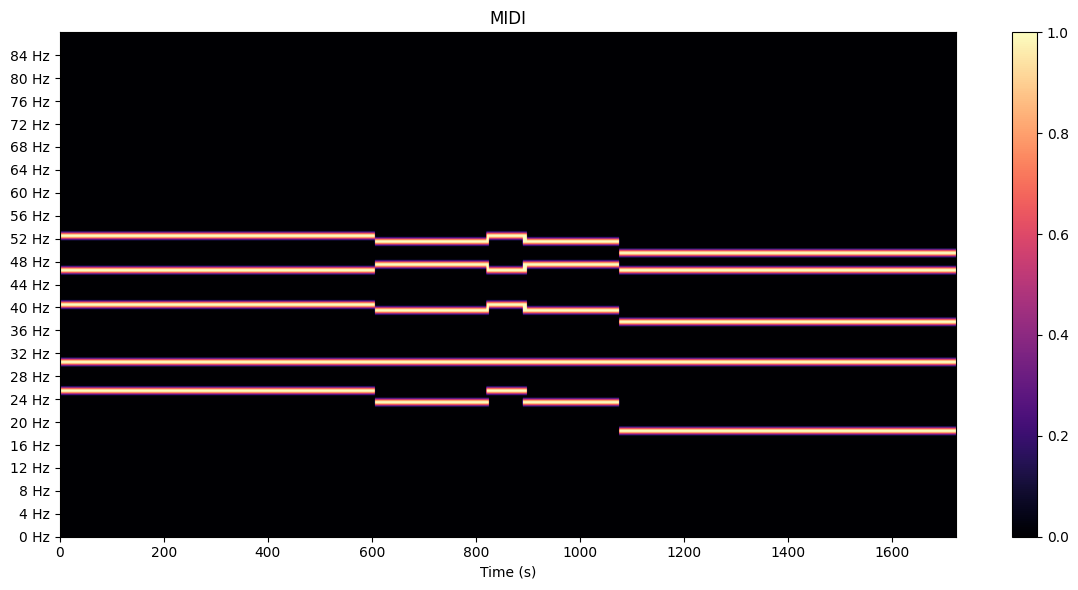

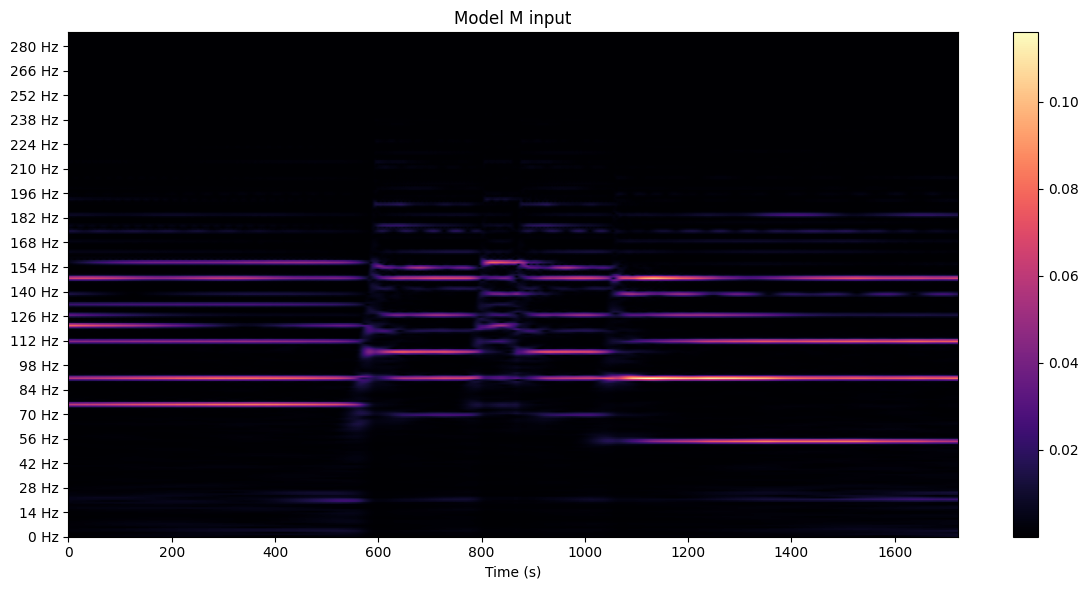

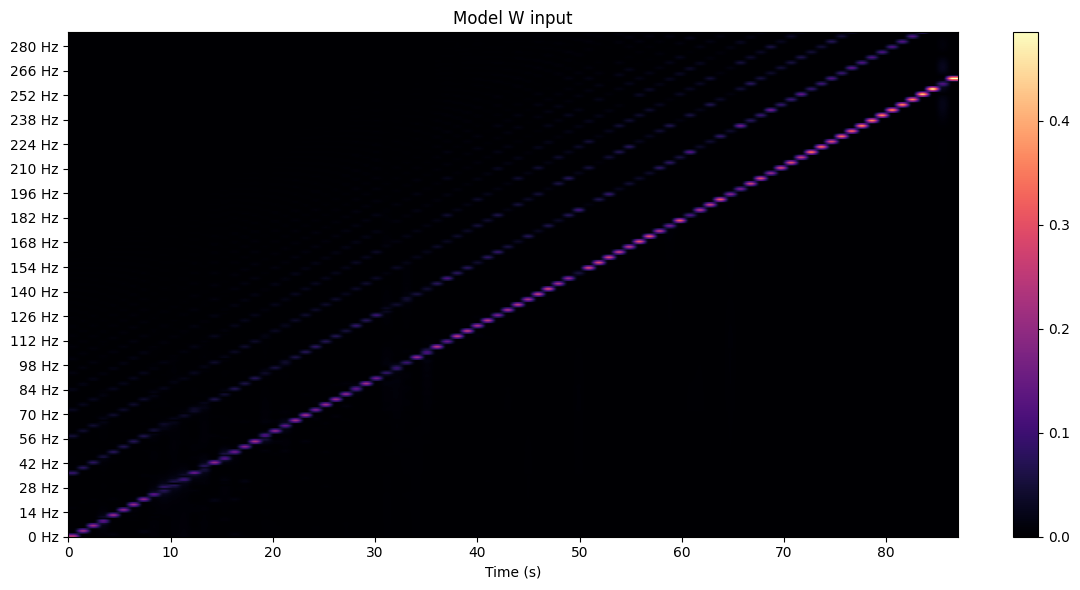

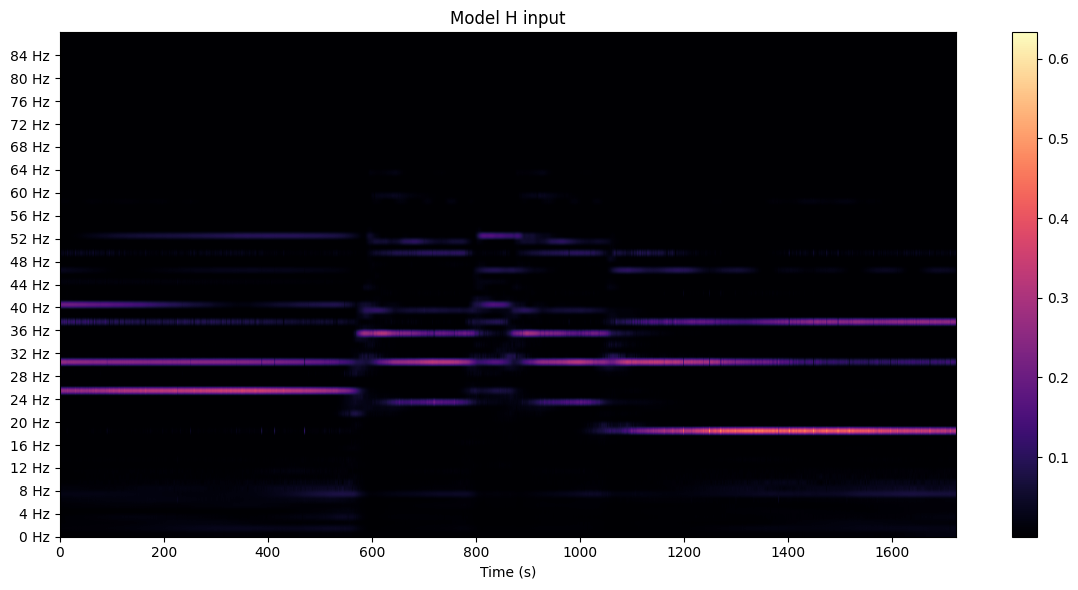

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from adasp_data_management import music
from torch.utils.data import DataLoader

split=0.8
length=10
subset=0.1
dtype=None
eps=1e-6
path = "/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv"
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'

mu = models.MU_NMF(n_iter=10, W_path=W_path)
ralmu = models.RALMU(W_path=W_path, n_init_steps=10, hidden=16, lambda_h=0.2, shared=True, return_layers=False)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt')
ralmu.load_state_dict(state_dict['model_state_dict'])

metadata = pd.read_csv(path)
train_data, test_data   = train_test_split(metadata, train_size=split, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=split, random_state=1)
train_data = train_data.reset_index(drop=True)
# test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print("Split the dataset - done ✓")

train_set   = utils.LocalDataset(train_data, use_midi=True, fixed_length=length, subset=subset, dtype=dtype)
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=1)
collate_fn = utils.create_collate_fn(use_midi=True)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate_fn)

for i, (M, H, midi) in enumerate(train_loader):
    if i == 0:
        continue
    elif i==1:
        with torch.no_grad():
            M = torch.clamp(M, min=eps)
            M = M.squeeze(0)
            M = M.to(dev)
            H = H.squeeze(0)
            H = H.to(dev)
            midi = midi.squeeze(0)
            midi = midi.to(dev)
            
            
            H_norm, norm_H = spec.l1_norm(H, threshold=0.01, set_min=eps)
            M_norm, norm_M = spec.l1_norm(M, threshold=0.01, set_min=eps)
            
            spec.vis_cqt_spectrogram(H_norm.cpu(), title="H")
            spec.vis_cqt_spectrogram(M_norm.cpu())
            spec.vis_cqt_spectrogram(midi.cpu(), title="MIDI")
            
            W_hat_ralmu, H_hat_ralmu, M_hat_ralmu, norm_ralmu = ralmu.forward(M_norm, device=dev)
            # H_hat_ralmu2 = H_hat_ralmu * norm_ralmu
            
            W_hat_mu, H_hat_mu, M_hat_mu, norm_mu = mu.forward(M_norm, device=dev)
            # H_hat_mu2 = H_hat_mu * norm_mu
    break

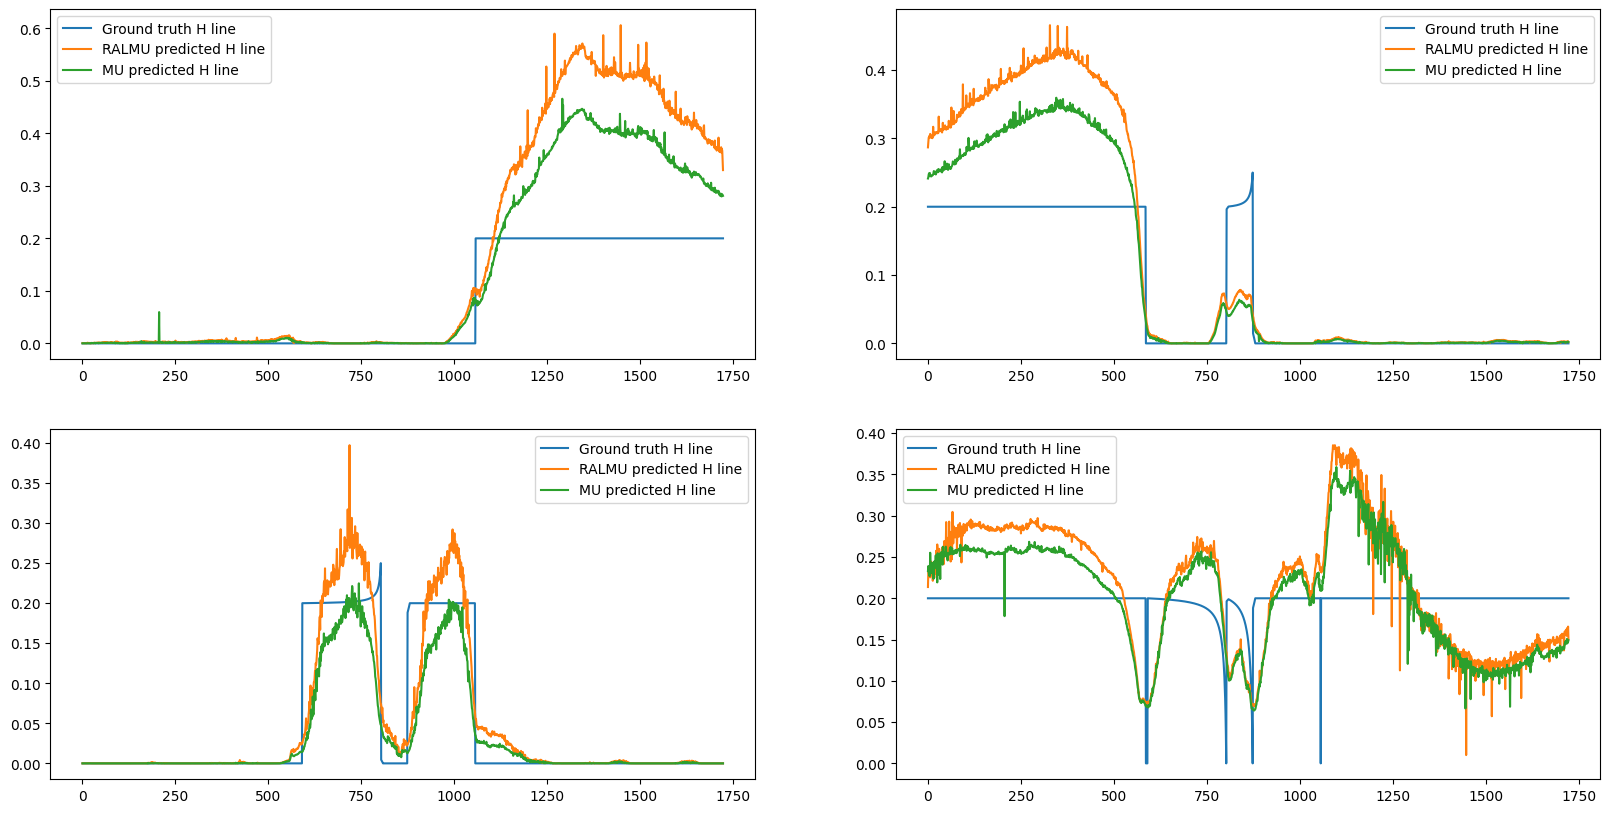

In [18]:
fig, axs = plt.subplots(2,2, figsize=(20,10))
# axs[0,0].set_yscale('log')
# axs[1,0].set_yscale('log')
# axs[0,1].set_yscale('log')
# axs[1,1].set_yscale('log')

active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]

axs[0,0].plot(H_norm[active_midi[0]].detach().cpu(), label="Ground truth H line")
axs[0,0].plot(H_hat_ralmu[active_midi[0]].detach().cpu(), label="RALMU predicted H line")
axs[0,0].plot(H_hat_mu[active_midi[0]].detach().cpu(), label="MU predicted H line")
axs[0,0].legend()

axs[1,0].plot(H_norm[active_midi[1]].detach().cpu(), label="Ground truth H line")
axs[1,0].plot(H_hat_ralmu[active_midi[1]].detach().cpu(), label="RALMU predicted H line")
axs[1,0].plot(H_hat_mu[active_midi[1]].detach().cpu(), label="MU predicted H line")
axs[1,0].legend()

axs[0,1].plot(H_norm[active_midi[2]].detach().cpu(), label="Ground truth H line")
axs[0,1].plot(H_hat_ralmu[active_midi[2]].detach().cpu(), label="RALMU predicted H line")
axs[0,1].plot(H_hat_mu[active_midi[2]].detach().cpu(), label="MU predicted H line")
axs[0,1].legend()

axs[1,1].plot(H_norm[active_midi[3]].detach().cpu(), label="Ground truth H line")
axs[1,1].plot(H_hat_ralmu[active_midi[3]].detach().cpu(), label="RALMU predicted H line")
axs[1,1].plot(H_hat_mu[active_midi[3]].detach().cpu(), label="MU predicted H line")
axs[1,1].legend()

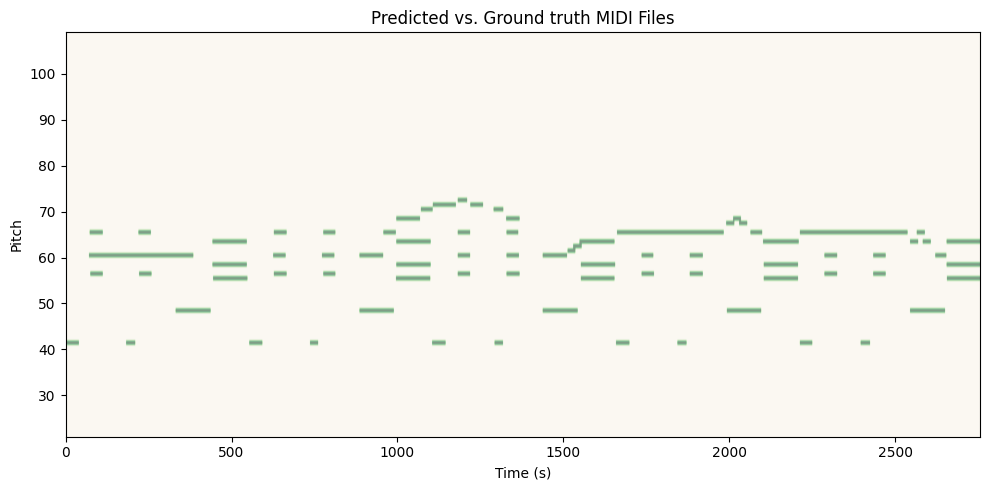

In [ ]:
_, notes_hat = init.W_to_pitch(W_hat.cpu(), true_freqs=None, use_max=True)
midi_hat, active_midi = init.WH_to_MIDI(W_hat, H_hat, notes_hat, normalize=False, threshold=0.1, smoothing_window=10, min_note_length=30, sr=44100)
spec.compare_midi(midi, midi_hat.detach())
spec.pianoroll_to_midi(midi_hat, "/home/ids/edabier/AMT/Unrolled-NMF/ralmu_midi_pred.mid", times)

### Compare MU and RALMU

In [11]:
import pandas as pd
import time
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

split=0.8
length=10
subset=0.1
dtype=None
batch=1
num_workers=1
n_iter=10

path = "/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv"
metadata = pd.read_csv(path)

train_data, test_data   = train_test_split(metadata, train_size=split, random_state=1)
test_data = test_data.reset_index(drop=True)
print("Split the dataset - done ✓")

test_set   = utils.LocalDataset(test_data, use_midi=True, fixed_length=length, cut_start_notes=False, subset=subset, dtype=dtype)
print("Loaded the datasets - done ✓")

test_sampler   = utils.SequentialBatchSampler(test_set, batch_size=batch)
collate_fn     = utils.create_collate_fn(use_midi=True) 
test_loader    = DataLoader(test_set, batch_sampler=test_sampler, collate_fn=collate_fn, num_workers=num_workers)
print("Created the dataloaders - done ✓")

Split the dataset - done ✓


0it [00:00, ?it/s]

5it [00:00, 20.90it/s]

Loaded the datasets - done ✓
Created the dataloaders - done ✓



/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()


In [ ]:
from adasp_data_management import music
maps = music.Maps("/tsi/mir/maps")
metadata = maps.pdf_metadata

In [6]:
# mt = test_set.metadata

# M = torch.load(f'/home/ids/edabier/{mt.iloc[0]["file_path"]}', map_location=dev)
# midi = torch.load(f'/home/ids/edabier/{mt.iloc[0]["midi_path"]}', map_location=dev)
# spec.compare_midi(midi, M)
# # spec.vis_cqt_spectrogram(midi)

Loaded the models - done ✓
Starting the testing on 389 files


[W822 16:41:43.059355138 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.062241955 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.064367126 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.066465480 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.068146120 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.070880322 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.071961677 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.073551957 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.075620153 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:41:43.076408694 NNPACK.cpp:57] Could not initialize NNPACK! Reason: Unsupported hardware.
[W822 16:4

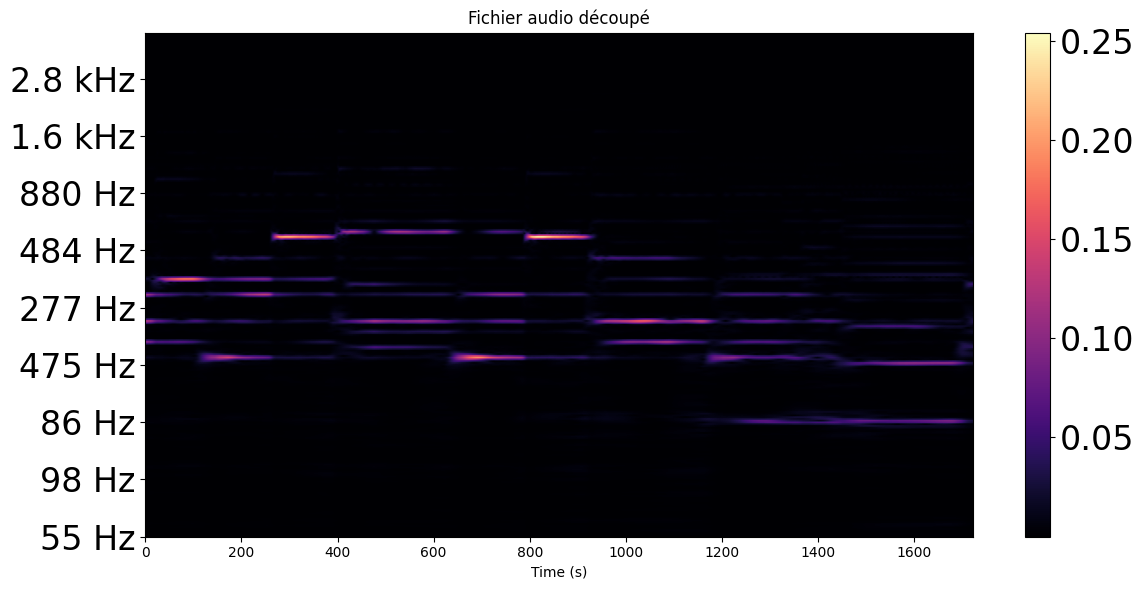

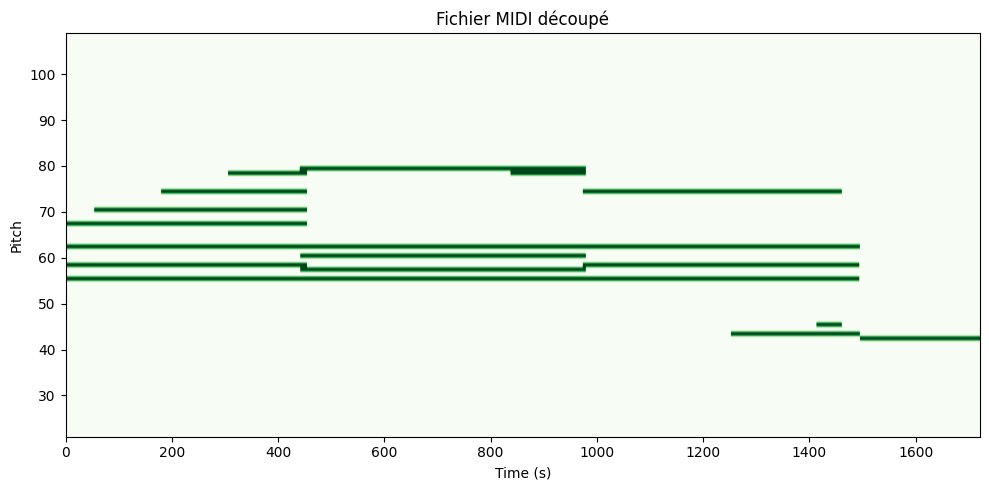

In [18]:
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, hidden=16, n_iter=n_iter, n_init_steps=1, shared=True, return_layers=False, aw_2d=False, clip_H=False, dtype=dtype)
ralmu = ralmu.to(dev)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt', map_location=dev)
ralmu.load_state_dict(state_dict['model_state_dict'])

mu_10 = models.MU_NMF(n_iter=10, W_path=W_path, beta=1, norm_thresh=0.01)
mu_10 = mu_10.to(dev)

mu_100 = models.MU_NMF(n_iter=100, W_path=W_path, beta=1, norm_thresh=0.01)
mu_100 = mu_100.to(dev)
print("Loaded the models - done ✓")

eps = 1e-6
threshs = torch.linspace(0.01, 10, 10)
metrics_ralmu = {"precision": [], "accuracy": [], "recall": [], "f_mesure": [], "inference_time": []}
metrics_mu_10 = {"precision": [], "accuracy": [], "recall": [], "f_mesure": [], "inference_time": []}
metrics_mu_100 = {"precision": [], "accuracy": [], "recall": [], "f_mesure": [], "inference_time": []}
ralmu.eval()

print(f"Starting the testing on {len(test_loader)} files")

for i, (M, H, midi) in enumerate(test_loader):
    if i < 2:
        continue
    elif i==2:
        with torch.no_grad():
            M = M.squeeze(0)
            midi = midi.squeeze(0)
            M = torch.clamp(M, min=eps)
            # M = M.to(dev)
            M, norm_M = spec.l1_norm(M, threshold=0.01, set_min=eps)
            
            midi = midi.to(dev)
            
            # spec.vis_cqt_spectrogram(M.cpu(), title="M")
            # spec.vis_midi(midi.cpu(), np.arange(midi.shape[1]), title=f"midi_{i}")
            
            # Tracking gpu usage
            # gpu_info = utils.get_gpu_info()
            # utils.log_gpu_info(gpu_info, filename="/home/ids/edabier/AMT/Unrolled-NMF/logs/gpu_info_log.csv")
            
            start_ralmu = time.time()
            W_hat_ralmu, H_hat_ralmu, M_hat_ralmu, norm_ralmu = ralmu(M, device=dev)
            # H_hat_ralmu = H_hat_ralmu * norm_ralmu
            stop_ralmu = time.time()
            inf_time_ralmu = stop_ralmu - start_ralmu
            
            # start_mu_10 = time.time()
            # W_hat_mu_10, H_hat_mu_10, M_hat_mu_10, _ = ralmu(M, device=dev)
            # stop_mu_10 = time.time()
            # inf_time_mu_10 = stop_mu_10 - start_mu_10
            
            # start_mu_100 = time.time()
            # W_hat_mu_100, H_hat_mu_100, M_hat_mu_100, _ = ralmu(M, device=dev)
            # stop_mu_100 = time.time()
            # inf_time_mu_100 = stop_mu_100 - start_mu_100
            
            # Tracking gpu usage
            # gpu_info = utils.get_gpu_info()
            # utils.log_gpu_info(gpu_info, filename="/home/ids/edabier/AMT/Unrolled-NMF/logs/gpu_info_log.csv")
            
            try:
                freqs, notes_hat_ralmu = init.W_to_pitch(W_hat_ralmu, true_freqs=None, use_max=True)
                # _, notes_hat_mu_10 = init.W_to_pitch(W_hat_mu_10, true_freqs=None, use_max=True)
                # _, notes_hat_mu_100 = init.W_to_pitch(W_hat_mu_100, true_freqs=None, use_max=True)
                best_f_ralmu = 0
                best_f_mu_10 = 0
                best_f_mu_100 = 0
                
                best_thresh_ralmu = threshs[0]
                best_thresh_mu_10 = threshs[0]
                best_thresh_mu_100 = threshs[0]
                
                for thresh in threshs:
                    midi_hat_ralmu, _ = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=100, sr=44100)
                    # midi_hat_mu_10, _ = init.WH_to_MIDI(W_hat_mu_10, H_hat_mu_10, notes_hat_mu_10, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=100, sr=44100)
                    # midi_hat_mu_100, _ = init.WH_to_MIDI(W_hat_mu_100, H_hat_mu_100, notes_hat_mu_100, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=100, sr=44100)
                    
                    prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi, midi_hat_ralmu, time_tolerance=1)
                    # prec_mu_100, rec_mu_10, f_mes_mu_10, accuracy_mu_10 = utils.compute_metrics(midi, midi_hat_mu_10, time_tolerance=1)
                    # prec_mu_100, rec_mu_100, f_mes_mu_100, accuracy_mu_100 = utils.compute_metrics(midi, midi_hat_mu_100, time_tolerance=1)
                    
                    if f_mes_ralmu > best_f_ralmu:
                        best_f_ralmu = f_mes_ralmu
                        best_thresh_ralmu = thresh
                        
                    # if f_mes_mu_10 > best_f_mu_10:
                    #     best_f_mu_10 = f_mes_mu_10
                    #     best_thresh_mu_10 = thresh
                        
                    # if f_mes_mu_100 > best_f_mu_100:
                    #     best_f_mu_100 = f_mes_mu_100
                    #     best_thresh_mu_100 = thresh
                        
                midi_hat_ralmu, _ = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=best_thresh_ralmu, smoothing_window=10, min_note_length=100, sr=44100)
                prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi, midi_hat_ralmu, time_tolerance=1)
                spec.vis_cqt_spectrogram(M.cpu(), frequencies=freqs, font_size=24, max_ticks=10, title="Fichier audio découpé")
                spec.vis_midi(midi.cpu(), np.arange(midi.shape[1]), title="Fichier MIDI découpé")
                # spec.compare_midi(midi.cpu(), midi_hat_ralmu.cpu(), title="MIDI prédit vs MIDI réel")
                # print(midi.shape, M.shape)
                # spec.compare_midi(midi.cpu(), M.cpu(), title="MIDI prédit vs MIDI réel")
                
                metrics_ralmu["precision"].append(prec_ralmu) 
                metrics_ralmu["recall"].append(rec_ralmu)
                metrics_ralmu["f_mesure"].append(f_mes_ralmu)
                metrics_ralmu["accuracy"].append(accuracy_ralmu)
                metrics_ralmu["inference_time"].append(inf_time_ralmu)
                    
                # midi_hat_mu_10, _ = init.WH_to_MIDI(W_hat_mu_10, H_hat_mu_10, notes_hat_mu_10, normalize=False, threshold=best_thresh_mu_10, smoothing_window=10, min_note_length=100, sr=44100)
                # prec_mu_10, rec_mu_10, f_mes_mu_10, accuracy_mu_10 = utils.compute_metrics(midi, midi_hat_mu_10, time_tolerance=1)
                # spec.compare_midi(midi.cpu(), midi_hat_mu_10.cpu(), title="MU 10")
                
                # metrics_mu_10["precision"].append(prec_mu_10) 
                # metrics_mu_10["recall"].append(rec_mu_10)
                # metrics_mu_10["f_mesure"].append(f_mes_mu_10)
                # metrics_mu_10["accuracy"].append(accuracy_mu_10)
                # metrics_mu_10["inference_time"].append(inf_time_mu_10)  
                    
                # midi_hat_mu_100, _ = init.WH_to_MIDI(W_hat_mu_100, H_hat_mu_100, notes_hat_mu_100, normalize=False, threshold=best_thresh_mu_100, smoothing_window=10, min_note_length=100, sr=44100)
                # prec_mu_100, rec_mu_100, f_mes_mu_100, accuracy_mu_100 = utils.compute_metrics(midi, midi_hat_mu_100, time_tolerance=1)
                # # spec.compare_midi(midi.cpu(), midi_hat_mu_100.cpu(), title="MU 100")
                
                # metrics_mu_100["precision"].append(prec_mu_100) 
                # metrics_mu_100["recall"].append(rec_mu_100)
                # metrics_mu_100["f_mesure"].append(f_mes_mu_100)
                # metrics_mu_100["accuracy"].append(accuracy_mu_100)
                # metrics_mu_100["inference_time"].append(inf_time_mu_100)
                
                # print(f"item {i}: \nRALMU: {metrics_ralmu}, \nMU 10: {metrics_mu_10}, \nMU 100: {metrics_mu_100}")
                
            except Exception as e:
                print(f"Skipping file {i} due to error: {e}")
                continue
    # elif i < 30:
    #     continue
    else:
        break


In [15]:
metrics_ralmu

{'precision': [0.125],
 'accuracy': [0.005714285714285714],
 'recall': [0.011363636363636364],
 'f_mesure': [0.020833333333333336],
 'inference_time': [14.767673254013062]}

Split the dataset - done ✓


16it [00:00, 31.61it/s]
/home/ids/edabier/AMT/Unrolled-NMF/src/utils.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.metadata.loc[:,'segment_indices'] = self.compute_length()


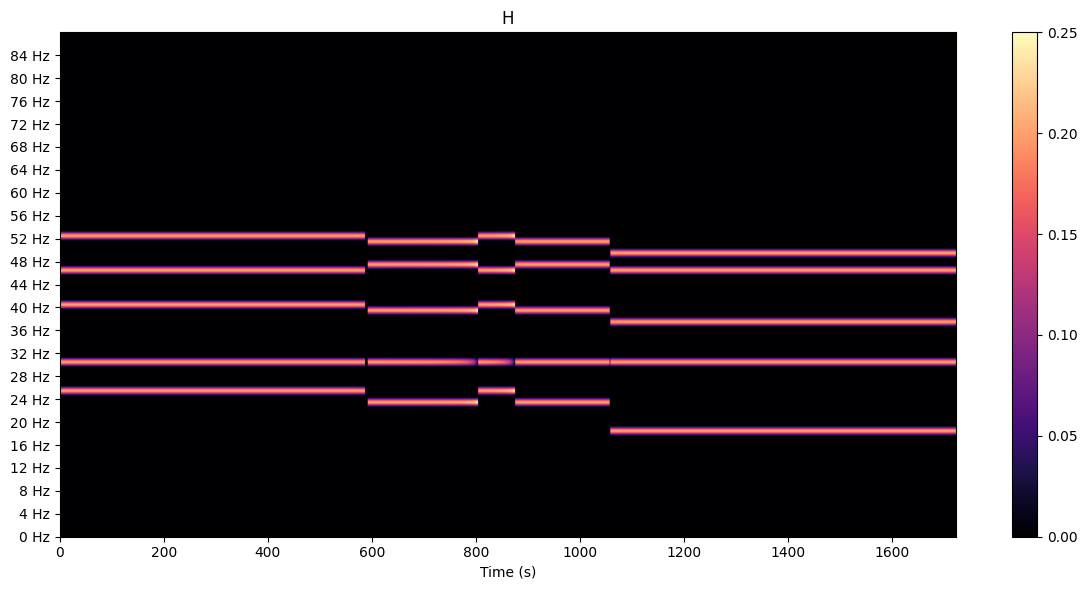

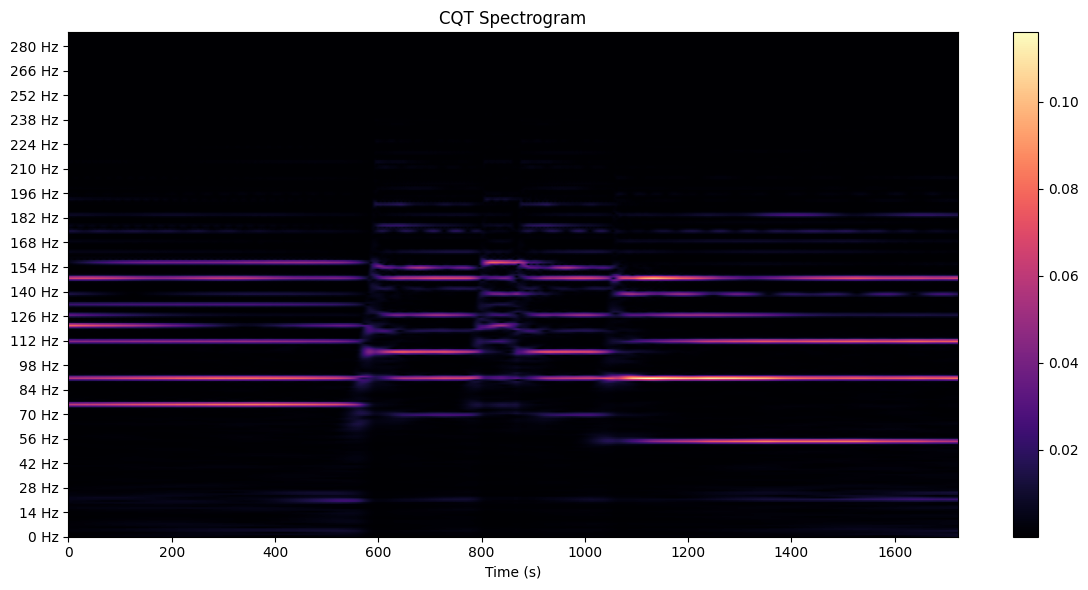

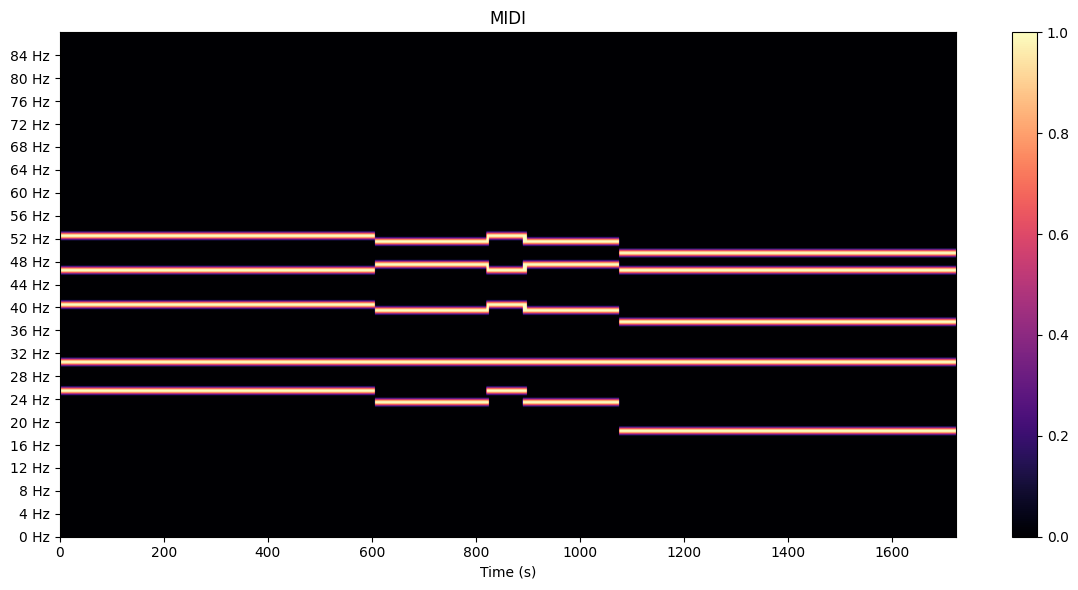

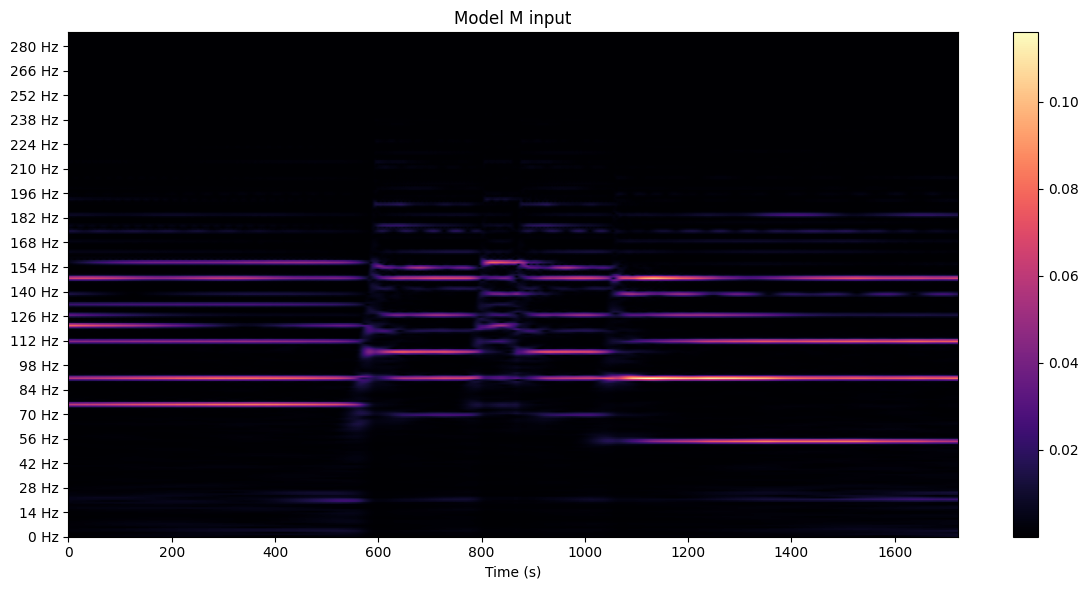

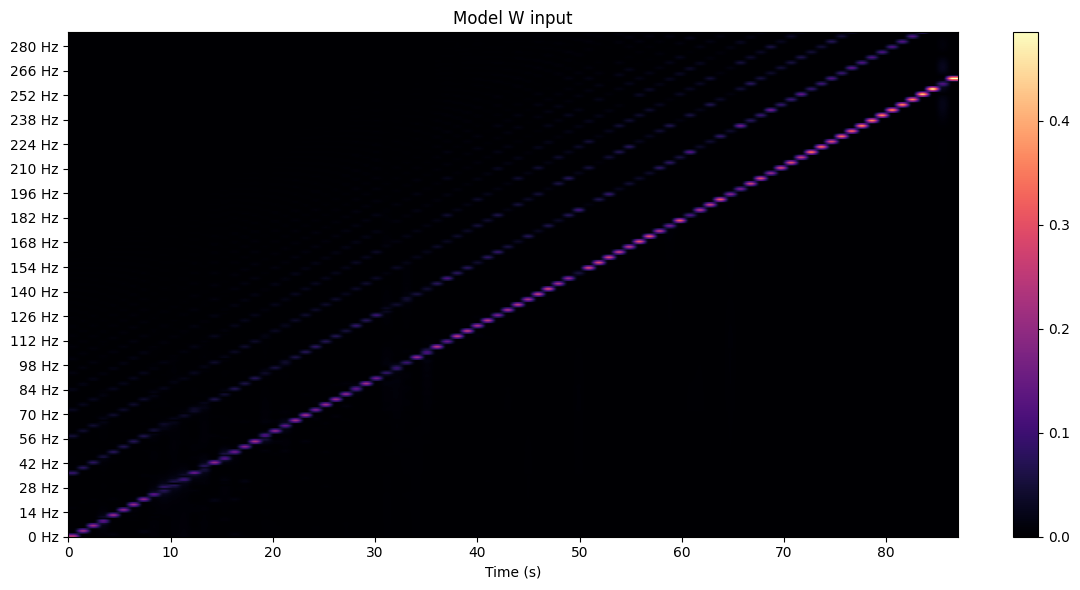

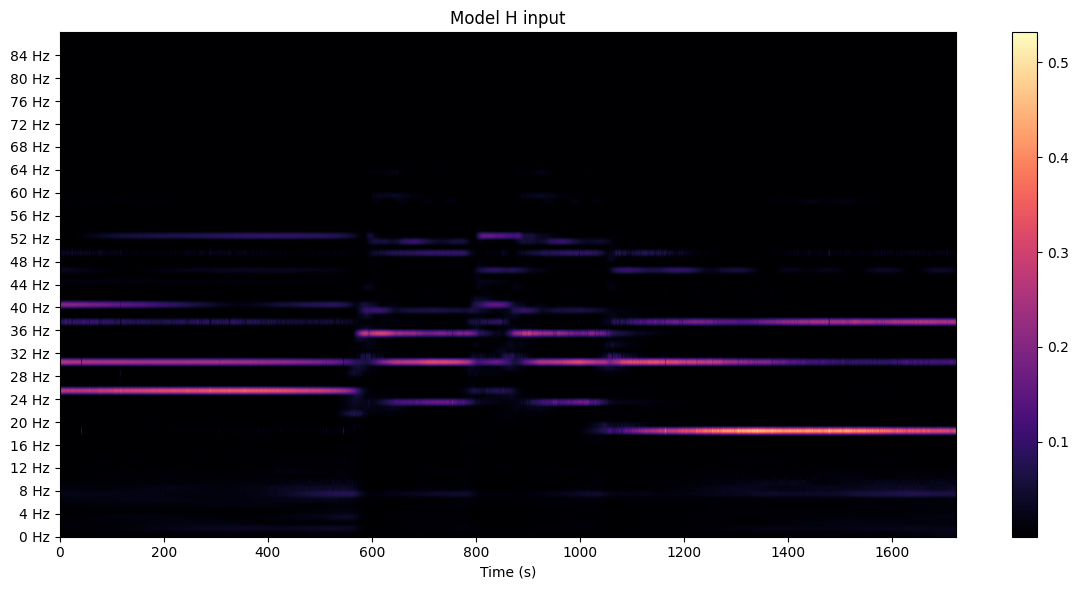

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from adasp_data_management import music
from torch.utils.data import DataLoader

split=0.8
length=10
subset=0.1
dtype=None
eps=1e-6
path = "/home/ids/edabier/AMT/Unrolled-NMF/MAPS/metadata.csv"
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'

mu = models.MU_NMF(n_iter=10, W_path=W_path)
ralmu = models.RALMU(W_path=W_path, n_init_steps=10, hidden=16, lambda_h=0.1, shared=True, return_layers=False)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt')
ralmu.load_state_dict(state_dict['model_state_dict'])

metadata = pd.read_csv(path)
# maps_meta = music.Maps("/tsi/mir/maps").pdf_metadata
train_data, test_data   = train_test_split(metadata, train_size=split, random_state=1)
train_data, valid_data  = train_test_split(train_data, train_size=split, random_state=1)
train_data = train_data.reset_index(drop=True)
# test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
print("Split the dataset - done ✓")

train_set   = utils.LocalDataset(train_data, use_midi=True, fixed_length=length, subset=subset, dtype=dtype)
train_sampler   = utils.SequentialBatchSampler(train_set, batch_size=1)
collate_fn = utils.create_collate_fn(use_midi=True)
train_loader    = DataLoader(train_set, batch_sampler=train_sampler, collate_fn=collate_fn)
# file_name = train_set.metadata.iloc[0]
# file_path = maps_meta[maps_meta['file_path'].str.contains(file_name, na=False)].file_path.values[0]

# y, sr = torchaudio.load(file_path)
for i, (M, H, midi) in enumerate(train_loader):
    if i == 0:
        continue
    elif i==1:
        with torch.no_grad():
            M = torch.clamp(M, min=eps)
            M = M.squeeze(0)
            M = M.to(dev)
            H = H.squeeze(0)
            H = H.to(dev)
            midi = midi.squeeze(0)
            midi = midi.to(dev)
            
            
            H_norm, norm_H = spec.l1_norm(H, threshold=0.01, set_min=eps)
            M_norm, norm_M = spec.l1_norm(M, threshold=0.01, set_min=eps)
            
            spec.vis_cqt_spectrogram(H_norm.cpu(), title="H")
            spec.vis_cqt_spectrogram(M_norm.cpu())
            spec.vis_cqt_spectrogram(midi.cpu(), title="MIDI")
            
            W_hat_ralmu, H_hat_ralmu, M_hat_ralmu, norm_ralmu = ralmu.forward(M_norm, device=dev)
            # H_hat_ralmu2 = H_hat_ralmu * norm_ralmu
            
            W_hat_mu, H_hat_mu, M_hat_mu, norm_mu = mu.forward(M_norm, device=dev)
            # H_hat_mu2 = H_hat_mu * norm_mu
    break

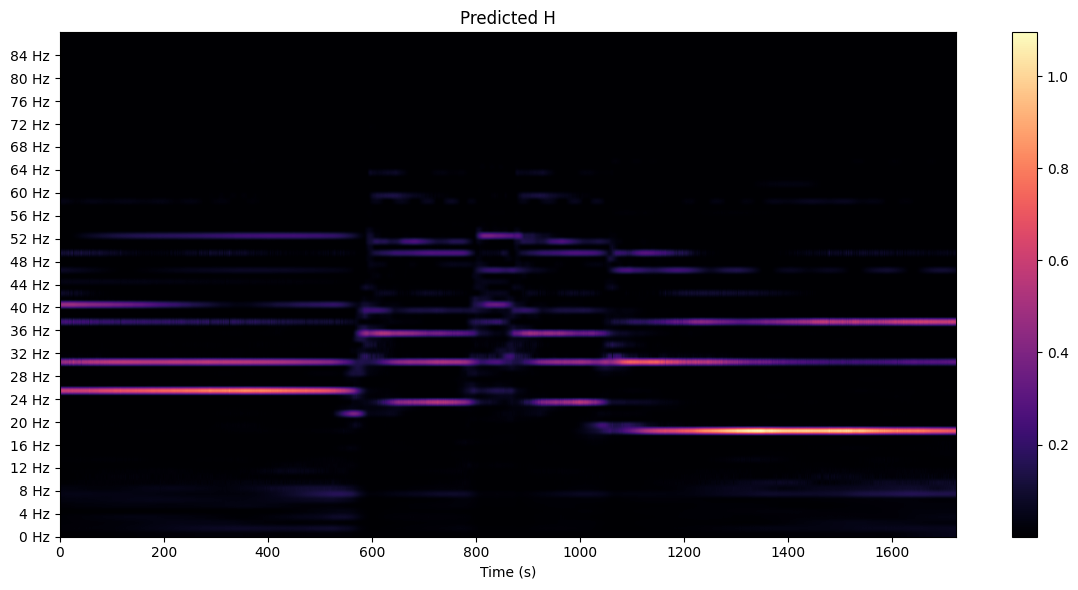

In [13]:
spec.vis_cqt_spectrogram(H_hat_ralmu.cpu(), title="Predicted H")

In [ ]:
_, notes_hat_ralmu = init.W_to_pitch(W_hat_ralmu.cpu(), true_freqs=None, use_max=True)
_, notes_hat_mu = init.W_to_pitch(W_hat_mu.cpu(), true_freqs=None, use_max=True)

threshs = torch.linspace(0.1, 10, 100)
best_thresh_ralmu = threshs[0]
best_f_ralmu = 0
best_thresh_mu = threshs[0]
best_f_mu = 0

for thresh in threshs:
    midi_hat_ralmu, active_midi_ralmu = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=thresh, smoothing_window=10, min_note_length=30, sr=44100)
    prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi_hat_ralmu, midi)
    
    if f_mes_ralmu > best_f_ralmu:
        best_f_ralmu = f_mes_ralmu
        best_thresh_ralmu = thresh
        
    midi_hat_mu, active_midi_mu = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=0.1, smoothing_window=10, min_note_length=30, sr=44100)
    prec_mu, rec_mu, f_mes_mu, accuracy_mu = utils.compute_metrics(midi_hat_mu, midi)
    
    if f_mes_mu > best_f_mu:
        best_f_mu = f_mes_mu
        best_thresh_mu = thresh


midi_hat_ralmu, active_midi_ralmu = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=best_thresh_ralmu, smoothing_window=10, min_note_length=30, sr=44100)
# midi_hat_ralmu, active_midi_ralmu = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=3, smoothing_window=10, min_note_length=30, sr=44100)
prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi_hat_ralmu, midi)
print(f"RALMU: {prec_ralmu}, {rec_ralmu}, {f_mes_ralmu}, {accuracy_ralmu}")

midi_hat_mu, active_midi_mu = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=best_thresh_mu, smoothing_window=10, min_note_length=30, sr=44100)
# midi_hat_mu, active_midi_mu = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=0.001, smoothing_window=10, min_note_length=30, sr=44100)
prec_mu, rec_mu, f_mes_mu, accuracy_mu = utils.compute_metrics(midi_hat_mu, midi)
print(f"MU: {prec_mu}, {rec_mu}, {f_mes_mu}, {accuracy_mu}")
# spec.compare_midi(midi.cpu(), midi_hat_ralmu.cpu())
# spec.vis_midi(midi.cpu(), np.arange(midi.shape[1]), 0, midi.shape[1])
# spec.vis_midi(midi_hat_ralmu.cpu(), np.arange(midi_hat_ralmu.shape[1]), 0, midi_hat_ralmu.shape[1])
# spec.vis_midi(midi_hat_mu.cpu(), np.arange(midi_hat_mu.shape[1]), 0, midi_hat_mu.shape[1])

In [ ]:
time_tolerance = 0.05
threshold = 0
min_note_length = 30

midi_hat_ralmu, active_midi_ralmu = init.WH_to_MIDI(W_hat_ralmu, H_hat_ralmu, notes_hat_ralmu, normalize=False, threshold=best_thresh_ralmu, smoothing_window=10, min_note_length=min_note_length, sr=44100)
prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu = utils.compute_metrics(midi_hat_ralmu, midi, time_tolerance=time_tolerance, threshold=threshold)
print(prec_ralmu, rec_ralmu, f_mes_ralmu, accuracy_ralmu)

midi_hat_mu, active_midi_mu = init.WH_to_MIDI(W_hat_mu, H_hat_mu, notes_hat_mu, normalize=False, threshold=best_thresh_mu, smoothing_window=10, min_note_length=min_note_length, sr=44100)
prec_mu, rec_mu, f_mes_mu, accuracy_mu = utils.compute_metrics(midi_hat_mu, midi, time_tolerance=time_tolerance, threshold=threshold)
print(prec_mu, rec_mu, f_mes_mu, accuracy_mu)

0.045112781954887216 0.24 0.0759493670886076 0.13636363636363635
0.009523809523809525 0.08 0.01702127659574468 0.041666666666666664


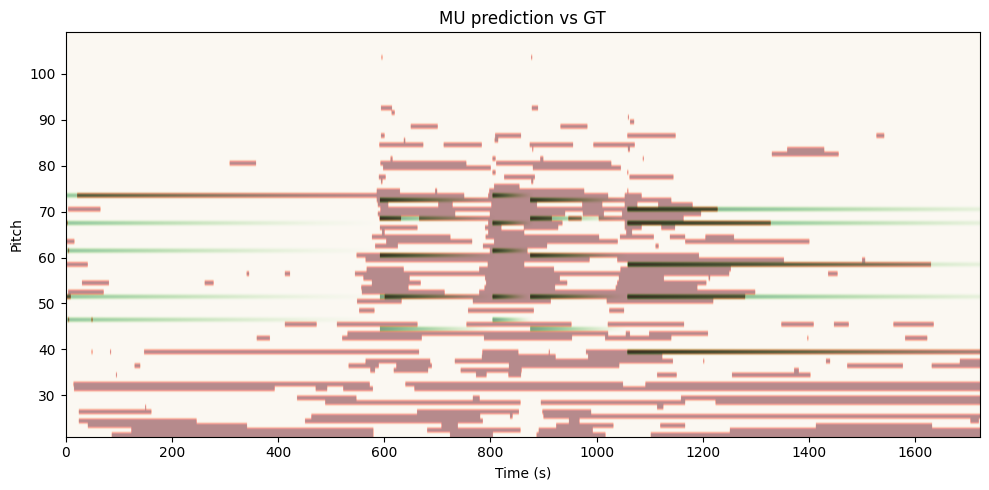

In [116]:
spec.compare_midi(midi.cpu(), midi_hat_mu.cpu(), title="MU prediction vs GT")

### Mean of metrics

In [ ]:
import pandas as pd
import numpy as np

metrics_ralmu = pd.read_csv("/home/ids/edabier/AMT/Unrolled-NMF/ralmu_metrics.csv")
metrics_ralmu.drop(["Unnamed: 0"], axis=1, inplace=True)
metrics_mu = pd.read_csv("/home/ids/edabier/AMT/Unrolled-NMF/mu_metrics.csv")
metrics_mu.drop(["Unnamed: 0"], axis=1, inplace=True)

metrics_mu.mean(axis=0)
metrics_ralmu.mean(axis=0)

### Total emissions for GPU usage

In [ ]:
total_energy_kwh, total_emissions_kwh, total_emissions_hour = utils.compute_emissions_2("/home/ids/edabier/AMT/Unrolled-NMF/logs/gpu_info_log.csv")
total_emissions_hour

precision         0.150633
accuracy          0.006008
recall            0.012142
f_mesure          0.022329
inference_time    3.786139
dtype: float64

In [ ]:
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
# mu = models.MU_NMF(n_iter=10, W_path=W_path, beta=1, norm_thresh=0.01)
mu = models.MU_NMF(n_iter=10, W_path=W_path, beta=1, norm_thresh=None)

y, sr = torchaudio.load("piano-dataset/audios/example-6.wav")

M, times, freqs_M = spec.cqt_spec(y, sr, normalize_thresh=None)
W, freqs, sample_rate, true_freqs = init.init_W(W_path, normalize_thresh=0.1)
H = init.init_H(l=88, t=M.shape[1], W=W, M=M, n_init_steps=10, device=dev)
# M, times, freqs_M = spec.cqt_spec(y, sr, normalize_thresh=0.1)
# midi, onset, offset, _ = spec.midi_to_pianoroll(f"piano-dataset/midis/example-7.mid", y, times, hop_length=128, sr=sr)

# M = M.to(dev)
W_hat, H_hat, M_hat, _ = mu(M, dev)
# freqs = [freq.cpu() for freq in freqs_M]
spec.vis_cqt_spectrogram(H.cpu(), frequencies=freqs_M, font_size=32, title="H à l'initialisation")
spec.vis_cqt_spectrogram(H_hat.cpu(), frequencies=freqs_M, font_size=32, title="H prédit par le modèle")

# _, notes_hat = init.W_to_pitch(W_hat, true_freqs=None, use_max=True)
# midi_hat, active_midi = init.WH_to_MIDI(W_hat, H_hat, notes_hat, normalize=False, threshold=0.1, smoothing_window=10, min_note_length=30, sr=sr)
# spec.compare_midi(midi.cpu(), midi_hat.cpu())
# prec, rec, f_mes, accuracy = utils.compute_metrics(midi, midi_hat, time_tolerance=1)
# print(f"precision: {prec}, recall: {rec}, f_mesure: {f_mes}, accuracy: {accuracy}")

In [7]:
W_path = '/home/ids/edabier/AMT/Unrolled-NMF/test-data/synth-single-notes'
ralmu = models.RALMU(l=88, beta=1, W_path=W_path, n_iter=10, hidden=16, n_init_steps=1, shared=True, return_layers=False, aw_2d=False, clip_H=False, dtype=None)
state_dict = torch.load('/home/ids/edabier/AMT/Unrolled-NMF/models/checkpoint.pt')
ralmu.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [ ]:
metrics = utils.test_model(mu, test_loader, dev)

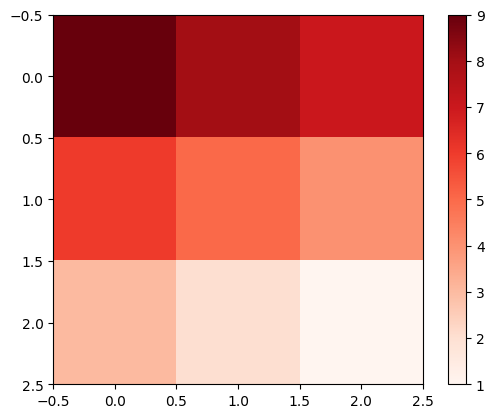

In [ ]:
aw = models.Aw_cnn()
ah = models.Ah_cnn()   
# tensor = torch.tensor([[[3., 3.,3.], [2.,2.,2.], [1.,1.,1.]], [[3., 3.,3.], [2.,2.,2.], [1.,1.,1.]]])
tensor = torch.tensor([[[9.,8.,7.], [6.,5.,4.], [3.,2.,1.]], [[9.,8.,7.], [6.,5.,4.], [3.,2.,1.]]])
plt.imshow(tensor[0], cmap='Reds')
plt.colorbar()

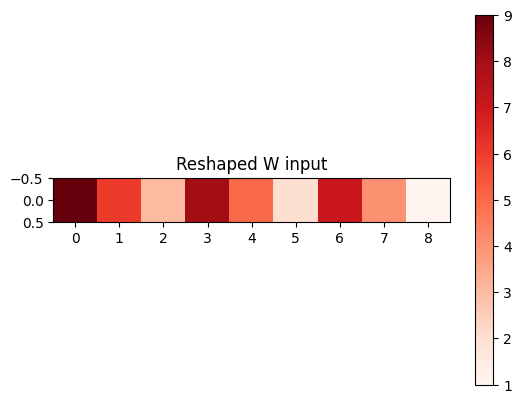

In [3]:
reshaped = tensor.transpose(1,2).reshape(tensor.shape[0], 1, tensor.shape[2] * tensor.shape[1])

plt.imshow(reshaped[0], cmap='Reds')
plt.title("Reshaped W input")
plt.colorbar()

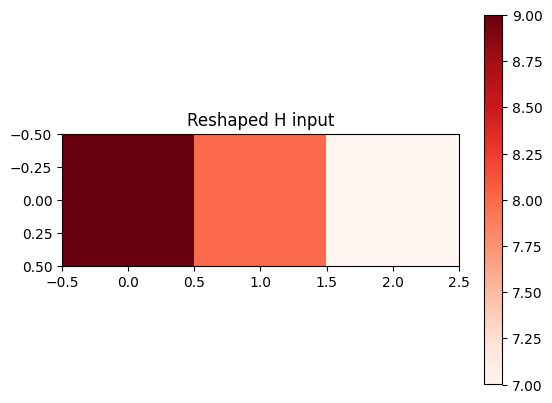

In [9]:
reshaped = tensor.view(tensor.shape[0] * tensor.shape[1], 1, tensor.shape[2])

plt.imshow(reshaped[0], cmap='Reds')
plt.title("Reshaped H input")
plt.colorbar()

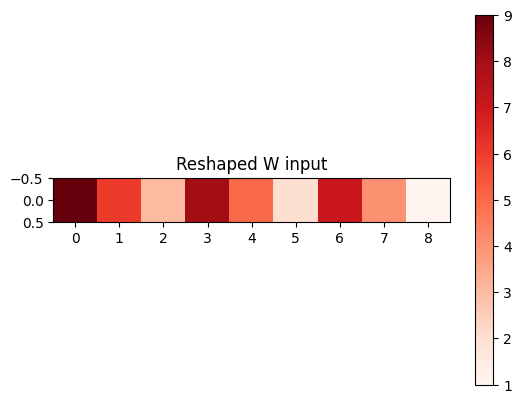

Aw reshaped: torch.Size([2, 1, 9])


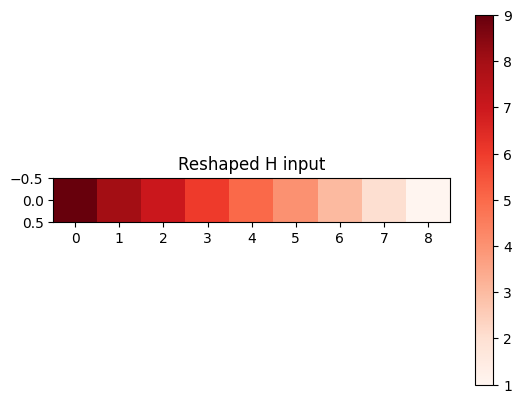

Ah reshaped: torch.Size([2, 1, 9])


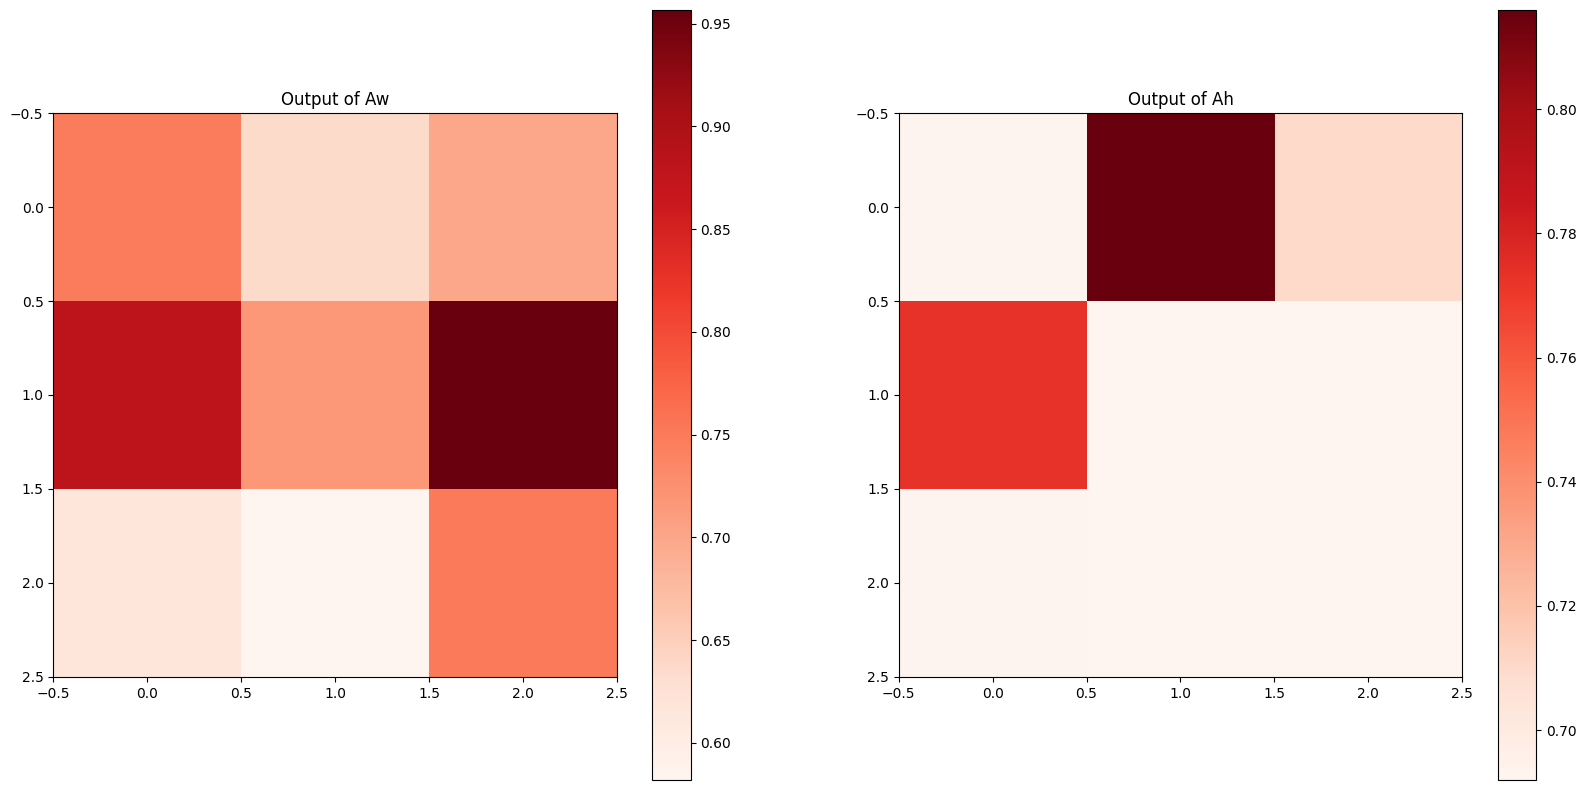

In [10]:
with torch.no_grad():
    y = aw(tensor)
    y2 = ah(tensor)

fig, axs = plt.subplots(1, 2, figsize= (20,10))
im1 = axs[0].imshow(y[0].detach(), cmap='Reds')
axs[0].set_title("Output of Aw")
plt.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(y2[0].detach(), cmap='Reds')
axs[1].set_title("Output of Ah")
plt.colorbar(im2, ax=axs[1])